In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-14 19:03:56,047 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

paths_train_feature += sorted(glob('../feature/valid_use/*_train.gz'))
paths_test_feature  += sorted(glob('../feature/valid_use/*_test.gz'))

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

  0%|          | 0/30 [00:00<?, ?it/s]

* Check Unique Feature.


100%|██████████| 30/30 [00:00<00:00, 44.96it/s]


  * 1 No Info Features: ['603__card2-card5_V243__ProductCD-W_std']
  * 1feature unique drop and move trush
['603__card2-card5_V243__ProductCD-W_std']
  * Diff Features: 0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.902014


2019-09-14 19:04:50,166 func.utils 111 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9020135532249385 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 26 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[140]	valid_0's auc: 0.93837


2019-09-14 19:05:17,822 func.utils 111 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9383702187239844 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 27 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.936341
Early stopping, best iteration is:
[152]	valid_0's auc: 0.936692


2019-09-14 19:05:44,337 func.utils 111 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.9366919286855266 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 25 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.934517
Early stopping, best iteration is:
[165]	valid_0's auc: 0.935282


2019-09-14 19:06:09,587 func.utils 111 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9352818292585067 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 24 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[92]	valid_0's auc: 0.944951


2019-09-14 19:06:29,263 func.utils 111 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9449508145343706 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 19 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.947016
Early stopping, best iteration is:
[241]	valid_0's auc: 0.947704


2019-09-14 19:07:05,760 func.utils 111 [INFO]    [ieee_cv]   * Fold5 2018-4: 0.9477041801118299 


[  * Fold5 Validation-DT-M 2018-4: 83571] done in 35 s
[  * Make Prediction Result File.] done in 60 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9516 / 0.921470613697238
  *  (506691,) (506691,)
  * LB0.95169 / 0.9564824730521286
  *  (506691,) (506691,)
  * LB0.9518 / 0.9613694379238129
  *  (506691,) (506691,)
  * LB0.9526 / 0.9485152125329541
* CV: 0.9341687540898594 | BestIter: 146.5
* Training Feature Importance


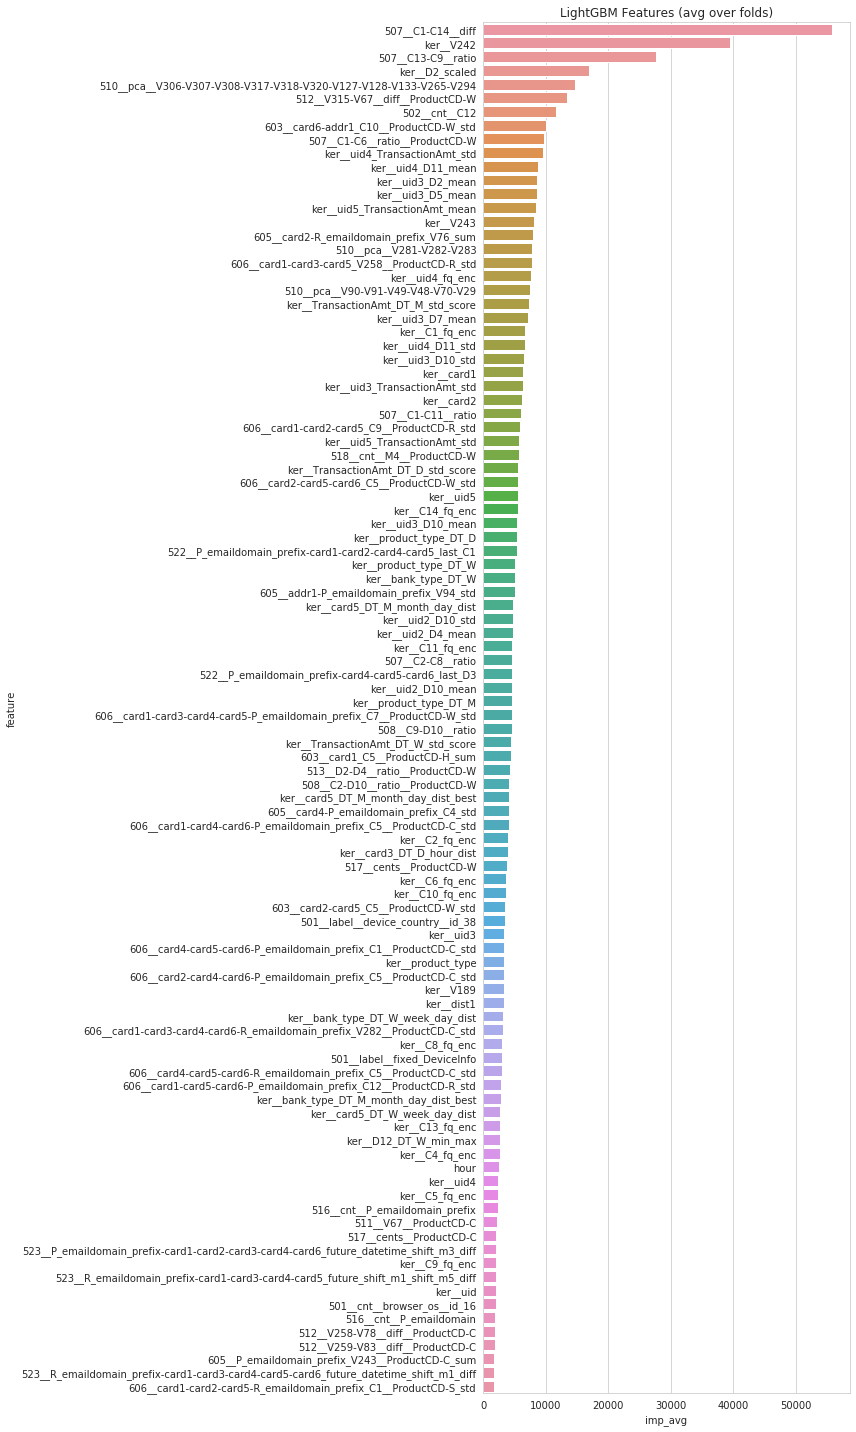

Setup Dataset dim_ml_dataset.


In [3]:
is_submit = [True, False][1]
valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

df_feat_train = parallel_load_data(valid_paths_train)
df_feat_test  = parallel_load_data(valid_paths_test)

col_drops = eval_check_feature(df_feat_train, df_feat_test)

tmp_train = df_train.join(df_feat_train)
tmp_test = df_test.join(df_feat_test)
# tmp_train = df_train
# tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 64,
    'n_jobs': 32,
    'seed': 1208,
    'n_splits': 6,
    'metric': 'auc',
    'model_type': model_type,
    'objective': 'binary',
    'fold': ['stratified', 'group'][1],
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.50,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
}

if is_submit:
    params['learning_rate'] = 0.01
    params["early_stopping_rounds"] = 100

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [6]:
pd.Series(read_pkl_gzip('../feature/org_use/508__C9-D7__ratio_train.gz')).value_counts()

0.0    38917
dtype: int64

In [4]:
# feim = read_pkl_gzip('../output/feature_importances/20190912_0822__CV0-9456328818476605__feature726.gz')
# pd.set_option('max_rows', 200)
feim = list_result_feim[0]
# idx = [idx for idx in feim.index if idx.count('522_')]
# feim = feim.loc[idx]
feim.tail(100)
# feim.loc[[i for i in feim.index if i.count('browser')]]

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__C2_fq_enc,3747.883789,3851.317871,3856.016602,4166.633301,3901.173828,4360.776367,3980.633545
ker__card3_DT_D_hour_dist,2908.856934,4235.589844,4008.468506,4368.670410,3038.400146,5196.314941,3959.383545
517__cents__ProductCD-W,3999.681641,2930.601074,3731.733887,4637.179688,3390.208496,4411.786621,3850.198486
ker__C6_fq_enc,3487.891357,3498.899902,4113.752441,4010.236816,3104.831299,3967.906982,3697.252930
ker__C10_fq_enc,938.610107,1035.711670,6055.099121,6295.813965,3111.739502,3966.025146,3567.166748
603__card2-card5_C5__ProductCD-W_std,2691.301270,3494.937256,3378.628418,3597.624023,3549.942871,3815.729248,3421.360352
501__label__device_country__id_38,3423.976318,3929.998047,2200.971191,2497.901611,4054.841797,4245.608398,3392.216064
ker__uid3,3414.668945,2767.637451,3981.096680,3524.326416,3379.379883,3228.056885,3382.527588
606__card4-card5-card6-P_emaildomain_prefix_C1__ProductCD-C_std,3014.016357,2972.773193,4181.178223,3841.547119,2517.314453,3652.414795,3363.207031


In [9]:
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim[feim['imp_avg']<50].index:
# for feature_name in feim.index:
#     if not feature_name.count('ker'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
    from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = 'valid_use'
    from_dir = 'org_use'
#     to_dir = 'valid_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
    to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
        print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

raw__R_emaildomain_mail_com_dummie
516__P_emaildomain_suffix_mx_dummie
516__R_emaildomain_suffix_es_dummie
516__R_emaildomain_suffix_us_dummie
516__P_emaildomain_suffix_es_dummie
516__R_emaildomain_suffix_fr_dummie
516__P_emaildomain_suffix_de_dummie
516__R_emaildomain_suffix_jp_dummie
516__P_emaildomain_suffix_fr_dummie
516__P_emaildomain_suffix_jp_dummie
516__R_emaildomain_suffix_uk_dummie
516__R_emaildomain_suffix_de_dummie
516__P_emaildomain_suffix_uk_dummie
